In [2]:
!pip install ipython-autotime

You should consider upgrading via the '/home/shashank/anaconda3/bin/python -m pip install --upgrade pip' command.


In [185]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.63 ms


In [186]:
import torch         
import torchvision
import torchvision.transforms as transforms

bth_size = 32

time: 611 µs


### If GPU is present use it otherwise use CPU

In [187]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
if (torch.cuda.is_available()):
    cuda = torch.device('cuda')

time: 635 µs


### Load dataset 

In [197]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bth_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bth_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
time: 1.97 s


In [194]:
#labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

time: 594 µs


### Preview CIFAR-10 dataset images

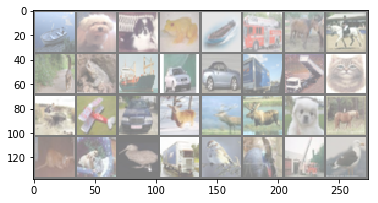

 ship   dog   dog  frog  ship truck horse horse   cat  frog  ship   car   car truck truck   cat   cat plane   car  deer  deer  deer   dog horse   cat   dog  bird truck  bird  bird truck  bird
time: 389 ms


In [198]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

### Setting up the layers of Convolutional neural network

In [277]:
in_size = 3                 # number of channel in the input image
 
hid1_size = 64              # no of output channel from first CNN layer

hid2_size = 128             # no of output channel from second CNN layer

hid3_size = 256             # no of output channel from third CNN layer

hid4_size = 512             # no of output channel from forth CNN layer

out_size = len(classes)     # no of categories in the dataset

k_conv_size = 3             # 3x3 convolutional kernel

conv_stride = 1             # conv stride 1

conv_pad = 1                # conv padding 1

maxpool_kernel = 2          # maxpool layer kernel size 2 x 2

maxpool_stride = 2          # maxpool layer stride 2

time: 1.16 ms


In [278]:
import torch.nn as nn

class VGG_11(nn.Module):
    
    def __init__(self):
        super(VGG_11,self).__init__()
        
        self.convLayer = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size, stride=conv_stride, padding=conv_pad),    # conv layer
            nn.BatchNorm2d(hid1_size),
            #nn.LocalResponseNorm(64),
            nn.ReLU(),                              # Activation layer
            nn.MaxPool2d(kernel_size=maxpool_kernel,stride=maxpool_stride),
            
            nn.Conv2d(hid1_size,hid2_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=maxpool_kernel,stride=maxpool_stride),
            
            nn.Conv2d(hid2_size,hid3_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid3_size),
            nn.ReLU(),
            
            nn.Conv2d(hid3_size,hid3_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid3_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=maxpool_kernel,stride=maxpool_stride),
            
            nn.Conv2d(hid3_size,hid4_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid4_size),
            nn.ReLU(),
            
            nn.Conv2d(hid4_size,hid4_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid4_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=maxpool_kernel,stride=maxpool_stride),
            
            nn.Conv2d(hid4_size,hid4_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid4_size),
            nn.ReLU(),
            
            nn.Conv2d(hid4_size,hid4_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid4_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=maxpool_kernel,stride=maxpool_stride), 
            
            #nn.Flatten(0,-1),
            
            #nn.Linear(512*bth_size, out_size)
            
        )
        
     
        self.fullyConnLayer = nn.Sequential(
            nn.Linear(512, out_size),
            #nn.Softmax(dim=1)
        )
            
        
    def forward(self,x):
            out = self.convLayer(x)

            out = out.reshape(out.size(0), -1)
            
            out = self.fullyConnLayer(out)
            
            return out 
        
vgg_11 = VGG_11()

time: 110 ms


## Define a Loss function and optimizer

In [268]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(vgg_11.parameters())

time: 1.69 ms


## Train the network

In [270]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = vgg_11(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # print statistics        
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 2.418
[1,   400] loss: 1.919
[1,   600] loss: 1.716
[1,   800] loss: 1.574
[1,  1000] loss: 1.488
[1,  1200] loss: 1.373
[1,  1400] loss: 1.282
Finished Training
time: 22min


### Save the trained model

In [261]:
PATH = './cifar_vgg11_4_with_batchNorm__no_softmax_5ep_GPU_1FCL_with_softmax.pth'
torch.save(vgg_11.state_dict(), PATH)

time: 101 ms


## Test the network on the test data

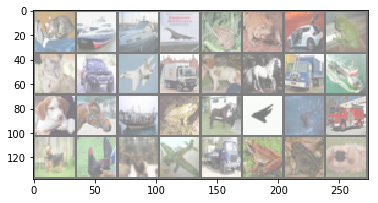

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog
time: 346 ms


In [271]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(32)))

In [272]:
outputs = vgg_11(images)

time: 327 ms


In [273]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(32)))

Predicted:    cat  ship  ship plane  frog  frog   dog  bird   cat   car  bird truck  deer horse truck  frog   dog horse   car  deer horse plane  bird truck  deer  frog   dog horse truck  frog   dog   dog
time: 3.53 ms


### Accuracy on whole test-dataset

In [274]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = vgg_11(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %
time: 1min 7s


### Which classes perform well and which classes did not?

In [31]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = vgg_11(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 80 %
Accuracy of   car : 90 %
Accuracy of  bird : 55 %
Accuracy of   cat : 61 %
Accuracy of  deer : 79 %
Accuracy of   dog : 74 %
Accuracy of  frog : 80 %
Accuracy of horse : 74 %
Accuracy of  ship : 86 %
Accuracy of truck : 91 %
time: 26.2 s (started: 2021-03-29 10:35:04 +02:00)
